## Calculating return period for cyclones in Mozambique

We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Mozambique. We'd like to have both: 
- An overall return period across all selected provinces
- A per-province return period

In [ ]:
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
import os

load_dotenv()
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
AA_DATA_DIR_NEW = os.getenv("AA_DATA_DIR_NEW")
THRESHOLD_SPEED = "80"
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]

## 1. Data loading and preparation

We'll start by loading in the required data sources below. We need the ADM1 boundaries (provinces) and the [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) `.shp` of cyclone tracks. We'll select only the provinces of interest from the admin boundaries file.

In [3]:
adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "moz" / "cod_ab" / "moz_admbnda_adm1_ine_20190607.shp"
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)] 

# TODO: Replace with local path
points_path = Path("/Users/hannahker/Google Drive/Shared drives/Predictive Analytics/CERF Anticipatory Action/Mozambique/2024 Framework Development/IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp")
lines_path = Path("/Users/hannahker/Google Drive/Shared drives/Predictive Analytics/CERF Anticipatory Action/Mozambique/2024 Framework Development/IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp")

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [11]:
# TODO: Some additional data shared from Tristan that might be useful
# wmo_speeds_path = Path(AA_DATA_DIR_NEW) / "public" / "processed" / "glb" / "ibtracs" / "ibtracs_with_wmo_wind.parquet"
# df_wmo_speeds = pd.read_parquet(wmo_speeds_path)

Let's also check that both datasets have the same CRS. Then we can select only the points within the polygons. We'll also clean up the columns and make sure points are sorted by time.

In [13]:
assert(gdf_points.crs == gdf_sel.crs == gdf_lines.crs)
gdf_points_sel = gpd.sjoin(gdf_points, gdf_sel, how='inner', predicate='within')
gdf_lines_sel = gpd.sjoin(gdf_lines, gdf_sel, how='inner', predicate='within')
gdf_points_sel_ = gdf_points_sel[["ADM1_PT", "NAME", "ISO_TIME", "REU_WIND", "WMO_WIND", "geometry"]].sort_values("ISO_TIME")

And plot for a basic sanity check

<Axes: >

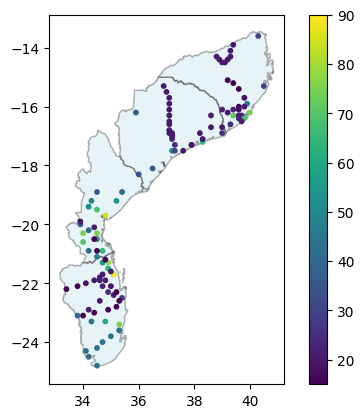

In [5]:
ax = gdf_sel.plot(color='lightblue', edgecolor='black', alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

Now we also want to get the maximum speed per storm track. 

**TODO: Interpolate to greater temporal frequency (eg. 30 mins)**

In [27]:
lines = []
for name, group in gdf_points_sel_.groupby('NAME'):
    # TODO: Interpolate to avoid groups of only 1 point
    if len(group) > 1:
        line = LineString(group['geometry'].tolist())
        lines.append({'NAME': name, 'geometry': line, "max_speed": group["REU_WIND"].max()})

gdf_tracks_joined = gpd.GeoDataFrame(lines, crs="EPSG:4326")

And plot again to sanity check

<Axes: >

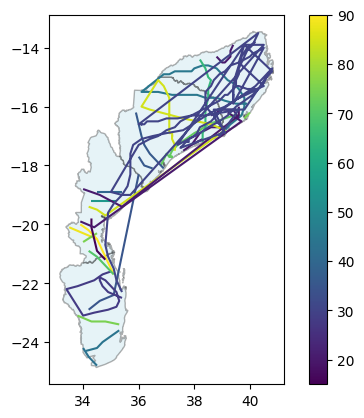

In [33]:
ax = gdf_sel.plot(color='lightblue', edgecolor='black', alpha=0.3)
gdf_tracks_joined.plot(ax=ax, column="max_speed", markersize=10, legend=True)

## 2. Return period calculation

How often do storms reach 80km/hr within these provinces?